In [ ]:
#Code for Duel DQN references https://github.com/bhctsntrk/OpenAIPong-DQN#orange_book-using-in-colab
#!nvidia-smi
!pip install --upgrade gym
!pip install 'gym[atari, accept-rom-license]'

In [ ]:
import gym
import cv2


import time
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import tensorflow as tf
import tqdm
from tqdm import trange
import seaborn as sns
from skimage.io import imread, imshow
from skimage.feature import hog
from sklearn.metrics.pairwise import euclidean_distances
from PER import *
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque
from gym.wrappers import Monitor

%matplotlib inline

In [ ]:
ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "pong-cnn-"  # Models path for saving or loading
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = False  # Train model while playing (Make it False when testing a model)

LOAD_MODEL_FROM_FILE = True  # Load model from file
LOAD_FILE_EPISODE = 900  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 10000  # Max episode
MAX_STEP = 10000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.97  # Discount rate
ALPHA = 0.05  # Learning rate
EPSILON_DECAY = 0.98  # Epsilon decay rate by step

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

In [ ]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean()) 

        return q

In [ ]:
def get_tensor(samples_traj, mode):
  '''
  Get rensor from array of sample trajectories
  '''
  if mode=='original':
    samples_tensor_traj = np.zeros((samples_traj.shape[0], samples_traj.shape[1]*samples_traj.shape[2]*samples_traj.shape[3]))
    for i in  range(samples_traj.shape[0]):
      samples_tensor_traj[i] = samples_traj[i].flatten()
  else:
    samples_tensor_traj = np.zeros((samples_traj.shape[0], samples_traj.shape[1], samples_traj.shape[2], samples_traj.shape[3]))
    for i in  range(samples_traj.shape[0]):
      samples_tensor_traj[i] = samples_traj[i]

  samples_tensor_traj = torch.tensor(samples_tensor_traj, dtype=torch.float32)
  
  return samples_tensor_traj

def overlay_frames(sample, weight_first, is_np = False):
  '''
  Stack 4 frames from sample into one with given weight weight_first given to the first combination
  is_np == True if numpy array
  '''
  if is_np == False:
    dst = cv2.addWeighted(sample[0].numpy(),weight_first,sample[1].numpy(),1-weight_first,0)
    dst = cv2.addWeighted(dst,weight_first,sample[2].numpy(),1-weight_first,0)
    dst = cv2.addWeighted(dst,weight_first,sample[3].numpy(),1-weight_first,0)
    return dst
  dst = cv2.addWeighted(sample[0],weight_first,sample[1],1-weight_first,0)
  dst = cv2.addWeighted(dst,weight_first,sample[2],1-weight_first,0)
  dst = cv2.addWeighted(dst,weight_first,sample[3],1-weight_first,0)
  return dst

def value_from_network(s, agent_):
  '''
  Returns value function predicted by DuelDQN
  s - state, agent_ - Agent instance
  '''
  s = torch.tensor(s, dtype=torch.float, device=DEVICE).unsqueeze(0)
  s = F.relu(agent_.online_model.bn1(agent_.online_model.conv1(s)))
  s = F.relu(agent_.online_model.bn2(agent_.online_model.conv2(s)))
  s = F.relu(agent_.online_model.bn3(agent_.online_model.conv3(s)))
  s = s.view(s.size(0), -1)
  V_pred = agent_.online_model.Vlrelu(agent_.online_model.Vlinear1(s))
  V_pred = agent_.online_model.Vlinear2(V_pred)

  return V_pred.detach().item()

In [ ]:
class Agent:
    def __init__(self, environment, random_policy):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = environment.action_space.n
        self.random_policy = random_policy

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.03  # Minimum for Explore

        # Replay memory (either prioritized (PER) or ordinary experience replay)
        self.USE_PER = True #if to use PER
        self.memory = deque(maxlen=MAX_MEMORY_LEN) #ordinary experience replay
        self.MEMORY = Memory(MAX_MEMORY_LEN)#prioritized experience replay

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval() #do not train target model - evaluation mode

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def storeResults(self, state, action, reward, next_state, done):
        '''
        Appends experience to memory
        '''
        experience = state[None, :], action, reward, next_state[None, :], done
        if self.USE_PER:
            self.MEMORY.store(experience)
        else:
            self.memory.append([experience])


    def preProcess(self, image):
        """
        Process image: crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Second option can be selected if explore  - select random action
        if exploit ask net for action
        """
        if self.random_policy:
            return np.random.choice([0,1,2,3,4,5])
        else:
            act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

            if act_protocol == 'Explore':
                action = random.randrange(self.action_size) #random action
            else:
                with torch.no_grad():
                    state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                    q_values = self.online_model.forward(state)  # (1, action_size)
                    action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

            return action



    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        if self.USE_PER:
          # Sample minibatch from the PER memory
          tree_idx, minibatch  = self.MEMORY.sample(BATCH_SIZE)
          state = np.zeros((BATCH_SIZE, 4, self.target_h, self.target_w))
          next_state = np.zeros((BATCH_SIZE, 4, self.target_h, self.target_w))
          action, reward, done = [], [], []
          for i in range(BATCH_SIZE):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])
        else:
          # Randomly sample minibatch from the deque memory
          state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))
          # Concat batches in one array
          # (np.arr, np.arr) ==> np.BIGarr
          state = np.concatenate(state)
          next_state = np.concatenate(next_state)
        

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value* (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()
        if self.USE_PER:
          for i in range(len(minibatch)):
              td_loss = np.abs(expected_q_value[i].detach() - selected_q_value[i]) + 1e-5
              # Update priority
              self.MEMORY.batch_update(tree_idx, td_loss)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

        
    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay    

In [ ]:
def get_rewards(samples, env_copies, env):
    rewards = np.zeros((samples.shape[0], 6)) #6 is number of actions
    for num_sample, X in enumerate(samples):
        for action in range(6):
            env.unwrapped.restore_state(env_copies[num_sample])
            _, r, _, _ = env.step(action)
            rewards[num_sample, action] = r
    return rewards



def getBounds(env, agent_rand, agent_pol, N, M1, M2, k, gamma, total_steps):
    #sns.set(style="darkgrid")

    n_actions = env.action_space.n

    # generate Y_states. These are next states for every state from sample for every action (repeated M1 times)
    # V_ns = torch.zeros((n_actions, N, M1))
    Y_pol = torch.zeros((n_actions, N, M1, 1))
    Y_rand = torch.zeros((n_actions, N, M1, 1))
    #Y_hogs = []
    st = []
    v_pol = []
    v_rand = []
    saved_env = []
    s = env.reset()
    s = agent_pol.preProcess(s)  # Process image
    s = np.stack((s, s, s, s))
    saved_environment = env.unwrapped.clone_state(include_rng=True)
    for i in tqdm.notebook.tqdm(range(N)):
        for action in range(n_actions):
            for j in range(M1):
                env.reset()
                env.unwrapped.restore_state(saved_environment)
                next_s, _, _, _ = env.step(action)
                next_s = agent_pol.preProcess(next_s)  # Process image
                next_s = np.stack((next_s, s[0], s[1], s[2]))
                #next_s = overlay_frames(next_s, 0.4, True)
                #vector_Y = hog(next_s)
                #Y_hogs.append(vector_Y)
                Y_pol[action, i, j] = value_from_network(next_s, agent_pol)#torch.from_numpy(vector_Y).float()
                Y_rand[action, i, j] = value_from_network(next_s, agent_rand)
        env.reset()
        env.unwrapped.restore_state(saved_environment)
        st.append(s)
        v_pol.append(value_from_network(s, agent_pol)) #td_value(state)
        v_rand.append(value_from_network(s, agent_rand))
        saved_env.append(saved_environment)
        action = agent_pol.act(s)  # ATTENTION!!!!!!!!!!!!!!!!!!!agent_.act(s) if non-random, np.random.choice([0,1,2,3,4,5]) if random
        next_state, reward, done, info = env.step(action)  # Observe
        next_state = agent_pol.preProcess(next_state)  # Process image
        next_state = np.stack((next_state, s[0], s[1], s[2]))
        s = next_state
        saved_environment = env.unwrapped.clone_state(include_rng=True)
    
    V_pi_pol = torch.from_numpy(np.array(v_pol.copy()))
    V_pi_rand = torch.from_numpy(np.array(v_rand.copy()))
    #samples = np.array(st.copy())
    samples_tensor = get_tensor(np.array(st), 'original')
    #N1 = samples.shape[0]

    #interpolation of value functions
    #train KNN for this
    #Preprocess frames
    gradient_vectors = []
    for i in range(N):
        image = overlay_frames(st[i], 0.4, True)
        vector = hog(image) #Histogram of oriented gradients as feature vector for frames
        gradient_vectors.append(vector)
        #distances = euclidean_distances(gradient_vectors, gradient_vectors) #calculate distance between states
    #sample_embed = TSNE(1).fit_transform(np.array(gradient_vectors), y = None)
    #sample_embed = np.array(gradient_vectors)
    neigh = NearestNeighbors(n_neighbors=k, algorithm='auto', leaf_size=100, n_jobs=-1, metric="euclidean")
    neigh.fit(gradient_vectors)

#   Y_embed = TSNE(1).fit_transform(np.array(Y_hogs), y = None)
    #Y_hogs = np.array(Y_hogs)
    #all = np.vstack((Y_hogs, sample_embed))
    #all_embed = TSNE(2).fit_transform(all, y = None)
    #plt.scatter(all_embed[:len(Y_hogs)+1,0], all_embed[:len(Y_hogs)+1, 1], c = 'r')
    #plt.scatter(all_embed[len(Y_hogs)+1:, 0], all_embed[len(Y_hogs)+1:, 1], c = 'b')
    #plt.show()
    
    #_, idxes_neigh1 = neigh.kneighbors(torch.flatten(Y, end_dim=2).numpy().tolist())
    V_ns_pol = Y_pol.mean(dim=-1).reshape(n_actions, N, M1)#V_pi[torch.tensor(idxes_neigh1)].squeeze().mean(dim=-1).reshape(n_actions, N, M1)
    V_ns_rand = Y_rand.mean(dim=-1).reshape(n_actions, N, M1)
    V_mean_pol = torch.mean(V_ns_pol, dim=-1, keepdims=True)
    V_mean_rand = torch.mean(V_ns_rand, dim=-1, keepdims=True)

    V_pi_pol = V_pi_pol.squeeze()
    V_pi_rand = V_pi_rand.squeeze()

    rewards = get_rewards(np.array(st), saved_env, env) #get rewards for every next action from current state
    rewards = torch.tensor(rewards.reshape(n_actions, N, 1))

    V_up_pol = (torch.zeros_like(V_pi_pol) + torch.max(V_pi_pol)).squeeze()
    V_up_rand = (torch.zeros_like(V_pi_rand) + torch.max(V_pi_rand)).squeeze()
    upper_list_pol = [V_up_pol.detach().numpy()]
    upper_list_rand = [V_up_rand.detach().numpy()]
    norm_list_upper_pol = []
    norm_list_upper_rand = []

    step = 0
    Y_hogs = []
    with trange(step, total_steps + 1) as progress_bar:
      for step in progress_bar:
        Y_pol = torch.zeros((n_actions, N, M2, 1))
        Y_rand = torch.zeros((n_actions, N, M2, 1))
        Y_approx = torch.zeros((n_actions, N, M2, 3888))
        s = env.reset()
        s = agent_pol.preProcess(s)  # Process image
        s = np.stack((s, s, s, s))
        saved_environment = env.unwrapped.clone_state(include_rng=True)
        for i in range(N):
          for j in range(M2):
            for action in range(3):
              env.reset()
              env.unwrapped.restore_state(saved_environment)
              next_s, _, _, _ = env.step(action)
              next_s = agent_pol.preProcess(next_s)  # Process image
              next_s = np.stack((next_s, s[0], s[1], s[2]))
              Y_pol[action, i, j] = value_from_network(next_s, agent_pol)
              Y_rand[action, i, j] = value_from_network(next_s, agent_rand)
              next_s = overlay_frames(next_s, 0.4, True)
              vector_Y = hog(next_s)
              Y_hogs.append(vector_Y)
              Y_approx[action, i, j] =torch.from_numpy(vector_Y).float()
          #st.append(s)
          #vval = value_from_network(s, agent_) #td_value(state)
          #v.append(vval)
          #saved_env.append(saved_environment)
          env.reset()
          env.unwrapped.restore_state(saved_environment)
          action = agent_pol.act(s)  # ATTENTION!!!!!!!!!!!!!!!!!!!agent_.act(s) if non-random, np.random.choice([0,1,2,3,4,5]) if random
          next_state, reward, done, info = env.step(action)  # Observe
          next_state = agent_pol.preProcess(next_state)  # Process image
          next_state = np.stack((next_state, s[0], s[1], s[2]))
          saved_environment = env.unwrapped.clone_state(include_rng=True)
          s = next_state

        _, idxes_neigh2 = neigh.kneighbors(torch.flatten(Y_approx, end_dim=2).numpy().tolist())
        
        V_k_pol = V_up_pol[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)
        V_pi_next_pol = Y_pol.mean(dim=-1).reshape(n_actions, N, M2)
        V_k_rand = V_up_rand[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)
        V_pi_next_rand = Y_rand.mean(dim=-1).reshape(n_actions, N, M2)#V_pi[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)
        #print('-----------------------')
        #print(rewards)
        #print(V_k)
        #print(V_mean)
        #print(V_pi_next)
        #print('-----------------------')
        V_up_pol = (rewards + gamma * (V_k_pol - V_pi_next_pol + V_mean_pol)).max(dim=0)[0].mean(dim=-1)
        V_up_rand = (rewards + gamma * (V_k_rand - V_pi_next_rand + V_mean_rand)).max(dim=0)[0].mean(dim=-1)
        upper_list_pol.append(V_up_pol.detach().numpy())
        upper_list_rand.append(V_up_rand.detach().numpy())
      

   # with trange(step, total_steps + 1) as progress_bar:
    #    for step in progress_bar:
#
    #        _, idxes_neigh2 = neigh.kneighbors(Y_distances)
#
    #        V_k = V_up[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)
    #        V_pi_next = V_pi[torch.tensor(idxes_neigh2)].mean(dim=-1).reshape(n_actions, N, M2)

     #       V_up = (rewards + gamma * (V_k - V_pi_next + V_mean)).max(dim=0)[0].mean(dim=-1)
     #       upper_list.append(V_up.detach().numpy())
    #Y_embed = TSNE(1).fit_transform(np.array(Y_hogs), y = None)
    #plt.plot(Y_embed)
    #plt.show()

    return V_up_pol, V_pi_pol, V_up_rand, V_pi_rand#, st, v
  
  
def plotBoundsRandomTraj_old(agent_, env, t, samples, V_pi, V_up, k, gamma=0.9, filename="Pong-traj.png"):
    samples_tensor = get_tensor(samples, 'original')
    traj, traj_envs, V_mont_traj = get_traj(1, agent_, t)
    traj_tensor = get_tensor(traj, 'original')

    gradient_vectors = []
    for i in range(samples_tensor.shape[0]):
        image = overlay_frames(samples[i], 0.4, True)
        vector = hog(image)
        gradient_vectors.append(vector)

    neigh = NearestNeighbors(n_neighbors=k, algorithm='auto', leaf_size=100, n_jobs=-1, metric="euclidean")
    neigh.fit(gradient_vectors)

    traj_tensor2 = []
    for j in range(traj_tensor.shape[0]):
      image = overlay_frames(traj[j], 0.4, True)
      vector = hog(image)
      traj_tensor2.append(vector)


    _, idxes_neigh = neigh.kneighbors(traj_tensor2)

    V_up_traj = V_up[torch.tensor(idxes_neigh)].mean(dim=-1)

    fig = plt.figure(figsize=(8, 7))
    sns.set(style="darkgrid")
    ax = fig.add_subplot(1, 1, 1)

    N_states = samples.shape[0]
    lower = V_pi
    upper = V_up_traj
    upper_plot = np.repeat(upper.reshape(-1, 1), repeats=2, axis=1).reshape(-1)
    lower_plot = np.repeat(lower.reshape(-1, 1), repeats=2, axis=1).reshape(-1)
    states_plot = np.concatenate((np.arange(N_states).reshape(-1,1),
                            (np.arange(N_states)+1).reshape(-1,1)), axis=1).reshape(-1)
    plt.fill_between(states_plot, lower_plot, upper_plot, alpha=0.5,
            edgecolor='k', linestyle='-', label="V_up - V_pi")
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("Trajectory States", fontsize=20)
    plt.plot(states_plot, upper_plot, states_plot, lower_plot, color='b')
    plt.plot(states_plot, lower_plot, states_plot, lower_plot, color = 'r')
    ax.set_xlim((0,20))
    ax.set_ylim((-2,2))
    ax.tick_params(axis="x", labelsize=25)
    ax.tick_params(axis="y", labelsize=25)
    plt.gcf().subplots_adjust(bottom=0.1, left = 0.2)

    plt.savefig(filename)

In [ ]:

def get_traj(n_samples, agent_, t):
    env= gym.make(ENVIRONMENT)
    states_list = []#trajectories
    values_at_states = []#values
    environment_copies_list = []#copies of environments when they are at particular state
    #plt.figure()
    for n in range(n_samples):
        for_plot = []
        state = env.reset()
        state = agent_.preProcess(state)  # Process image
        state = np.stack((state, state, state, state))

        total_step = 0

        while True:
            saved_environment = env.unwrapped.clone_state(include_rng=True)
            environment_copies_list.append(saved_environment)

            states_list.append(state)
            state_value = value_from_network(state, agent_) #td_value(state)
            values_at_states.append(state_value)
            #state_ = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
            #q_vals = (agent.online_model.forward(state_)).cpu()[0].detach().numpy()
            #value_at_state = sum(list(map(lambda a: ((a == np.argmax(q_vals))*(1 - agent.epsilon + agent.epsilon/6 ) + (a != np.argmax(q_vals))*(agent.epsilon/6 ))*q_vals[a], range(q_vals.shape[0]) )))
            #values_at_state.append(value_at_state)

            #environment.unwrapped.restore_state(saved_environment)
            action = agent_.act(state)  # Act
            next_state, reward, done, info = env.step(action)  # Observe
            next_state = agent_.preProcess(next_state)  # Process image
            next_state = np.stack((next_state, state[0], state[1], state[2]))
            #xx = overlay_frames(next_state, 0.4, True)
            #xx = hog(xx)
            #for_plot.append(xx)
            # Store the transition in memory
            agent_.storeResults(state, action, reward, next_state, done) 


            state = next_state
            total_step += 1
            if done or total_step >= t:
               # print('Episode ends. Total steps made:', total_step)
                #embed = TSNE(1).fit_transform(np.array(for_plot), y = None)
                #plt.plot(embed)
                #plt.show()
                break

    samples = np.array(states_list)
    values_at_states = np.array(values_at_states)
  #return torch.FloatTensor(np.vstack(samples)), environment_copies_list, torch.FloatTensor(np.vstack(values_at_states))
    return samples, environment_copies_list,  torch.from_numpy(values_at_states) 

In [ ]:
#create non-random agent
environment = gym.make(ENVIRONMENT) #Monitor(gym.make(ENVIRONMENT),'./video', force=True)  # Get env
agent_policy = Agent(environment, random_policy = False)  # Create Agent
LOAD_MODEL_FROM_FILE = True
LOAD_FILE_EPISODE = 900
if LOAD_MODEL_FROM_FILE:
    agent_policy.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl", map_location=torch.device('cpu')))
    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent_policy.epsilon = param.get('epsilon')
    startEpisode = LOAD_FILE_EPISODE + 1
else:
    startEpisode = 1

#create random agent
agent_random = Agent(environment, random_policy = True)
LOAD_MODEL_FROM_FILE = True
LOAD_FILE_EPISODE = 480
if LOAD_MODEL_FROM_FILE:
    agent_random.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl", map_location=torch.device('cpu')))
    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent_random.epsilon = param.get('epsilon')
    startEpisode = LOAD_FILE_EPISODE + 1
else:
    startEpisode = 1

In [ ]:
#t = 10
#n_samples = 3
#samples, _, _ = get_traj(n_samples, agent, t = t)
#samples.shape
#_, _, V_pi_rand = get_traj_random(n_samples, agent, t = t)

In [ ]:
#n_samples = 1
#t = 10
#samples, env_copy, V_pi = get_traj(n_samples, agent, t = t)
#V_up, samples, V_pi = getBounds(50, samples, env_copy, agent, environment, V_pi, 0.99, 7, 7, 3)
valup_pol,val_pol, valup_rand, val_rand = getBounds(environment, agent_random, agent_policy, 30, 20, 20, 3, 0.99, 10)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 11/11 [05:26<00:00, 29.64s/it]


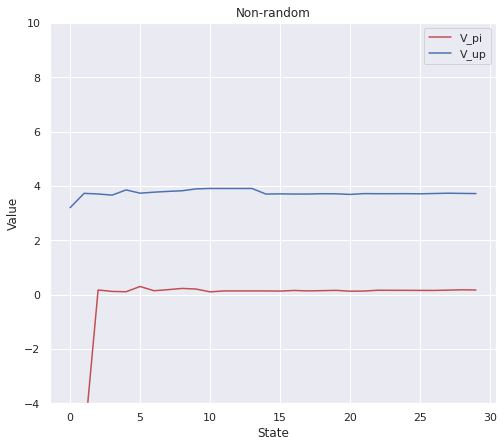

In [ ]:
fig = plt.figure(figsize=(8, 7))
sns.set(style="darkgrid")
plt.plot(val_pol, c = 'r', label='V_pi')
plt.plot(valup_pol, c = 'b', label = 'V_up')
plt.title('Non-random')
plt.xlabel('State')
plt.ylabel('Value')
plt.ylim(-4, 10)
plt.legend();

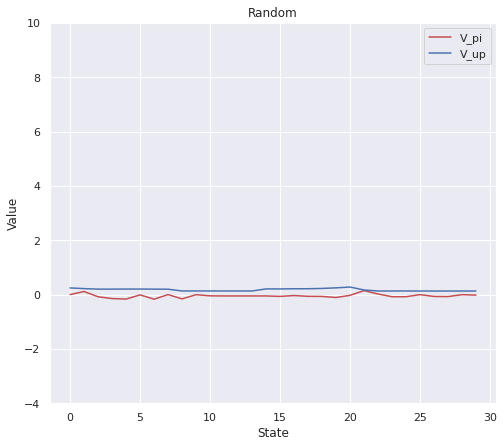

In [ ]:
fig = plt.figure(figsize=(8, 7))
sns.set(style="darkgrid")
plt.plot(val_rand, c = 'r', label='V_pi')
plt.plot(valup_rand, c = 'b', label = 'V_up')
plt.title('Random')
plt.xlabel('State')
plt.ylabel('Value')
plt.ylim(-4, 10)
plt.legend();

In [ ]:
len(V_up_rand)

100

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


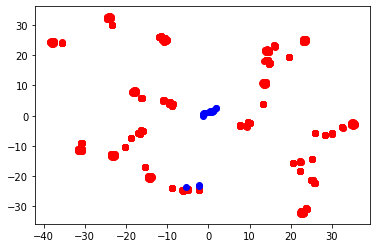

100%|██████████| 31/31 [02:08<00:00,  4.15s/it]


In [ ]:
n_samples = 10
t = 3
samples, env_copy, V_pi = get_traj(n_samples, agent, t = t)
V_up_rand, samples_rand, V_pi_rand = getBounds_random(20, samples, env_copy, agent, environment, V_pi, 0.99, 5, 5, 3)

In [ ]:
len(V_pi_rand)

640

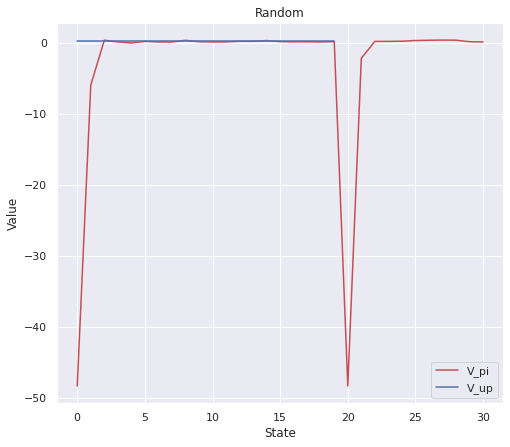

In [ ]:
fig = plt.figure(figsize=(8, 7))
sns.set(style="darkgrid")
plt.plot(V_pi_rand[:31], c = 'r', label = 'V_pi')
plt.plot(V_up_rand, c = 'b', label = 'V_up')
plt.title('Random')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()

In [ ]:
plotBoundsRandomTraj_old(agent, environment, t, np.array(samples), V_pi, V_up, 3, gamma=0.99, filename="Pong-traj.png")#not random

In [ ]:
plotBoundsRandomTraj_old(agent, environment, t, samples_rand, V_pi_rand, V_up_rand, 3, gamma=0.99, filename="Pong-traj.png")#not random

  0%|          | 0/1 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
environment = Monitor(gym.make(ENVIRONMENT),'./video', force=True)  # Get env
agent = Agent(environment, random_policy=True)  # Create Agent
losses = []
rewards = []
LOAD_MODEL_FROM_FILE = False
TRAIN_MODEL = True
if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl", map_location=torch.device('cpu')))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1

else:
    startEpisode = 1

last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
total_step = 1  # Cumulative sum of all steps in episodes
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # Keep time
    state = environment.reset()  # Reset env

    state = agent.preProcess(state)  # Process image

    # Stack state . Every state contains 4 time contionusly frames
    # We stack frames like 4 channel image
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):

        if RENDER_GAME_WINDOW:
            environment.render()  # Show state visually

        # Select and perform an action
        action = agent.act(state)  # Act
        next_state, reward, done, info = environment.step(action)  # Observe

        next_state = agent.preProcess(next_state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Move to the next state
        state = next_state  # Update state

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
        else:
            loss, max_q_val = [0, 0]
        losses.append(loss)
        rewards.append(reward)
        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            agent.adaptiveEpsilon()  # Decrase epsilon

        if done:  # Episode completed
            currentTime = time.time()  # Keep current time
            time_passed = currentTime - startTime  # Find episode duration
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
            epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")

            break


Episode:1 Time:16:01:23 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-21.000 Avg_Max_Q:0.000 Epsilon:1.00 Duration:2.62 Step:824 CStep:826
Episode:2 Time:16:01:25 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.500 Avg_Max_Q:0.000 Epsilon:0.98 Duration:2.10 Step:960 CStep:1787
Episode:3 Time:16:01:26 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.333 Avg_Max_Q:0.000 Epsilon:0.96 Duration:1.16 Step:1113 CStep:2901
Episode:4 Time:16:01:27 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.250 Avg_Max_Q:0.000 Epsilon:0.94 Duration:0.93 Step:919 CStep:3821
Episode:5 Time:16:01:28 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.400 Avg_Max_Q:0.000 Epsilon:0.92 Duration:0.86 Step:845 CStep:4667
Episode:6 Time:16:01:29 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.500 Avg_Max_Q:0.000 Epsilon:0.90 Duration:0.97 Step:960 CStep:5628
Episode:7 Time:16:01:30 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.429 Avg_Max_Q:0.000 Epsilon:0.89 Duration:0.97 Step:949 CStep:6578
Episode:8 Time:16:01:31 Reward:-21.00 Loss:0.00 

KeyboardInterrupt: ignored